# Applying Direction Vectors to Generated Images

### Setup

In [7]:
import os
import sys
sys.path.append('stylegan2/')
import torch
import numpy as np
from sklearn import svm
import dnnlib
import legacy
from PIL import Image


# Load the pre-trained model
network_pkl = './stylegan2/models/cars-network.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

# Load the model
with open(network_pkl, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # Assuming 'G_ema' is the generator

CUDA is available. Using GPU.


### WARNING MANAGEMENT

When used, the generator will show the following errors:
>UserWarning: Failed to build CUDA kernels for upfirdn2d. Falling back to slow reference implementation. Details:
Traceback (most recent call last):
  File "/home/juan/git/ControlledGeneration/stylegan2/torch_utils/ops/upfirdn2d.py", line 32, in _init
    _plugin = custom_ops.get_plugin('upfirdn2d_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juan/git/ControlledGeneration/stylegan2/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/juan/git/ControlledGeneration/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py", line 1312, in load
    return _jit_compile(
           ^^^^^^^^^^^^^
  File "/home/juan/git/ControlledGeneration/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py", line 1747, in _jit_compile
    return _import_module_from_library(name, build_directory, is_python_module)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juan/git/ControlledGeneration/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py", line 2141, in _import_module_from_library
    module = importlib.util.module_from_spec(spec)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 813, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1289, in create_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
ImportError: /home/juan/.cache/torch_extensions/py312_cu118/upfirdn2d_plugin/upfirdn2d_plugin.so: cannot open shared object file: No such file or directory


This error occurs for 2 reasons: 
 - C++ Compiler and libraries are not setup. To fix install all necessary dependencies.
 - Cuda version is not  10.1 (only for ubuntu 18.04)
To fix use an ubuntu 18.04 env with the dated [cuda 10.1](https://developer.nvidia.com/cuda-10.1-download-archive-base?target_os=Linux&target_arch=x86_64&target_distro=Ubuntu&target_version=1810). It is possible that any version of cudatoolkit that works with Torch 1.x will work but this will require at most ubuntu 20.04

If done correctly this line of code must run without errors:
> python -c "import torch; import upfirdn2d_op; import fused; print('OK')"

Otherwise, run the next block to suppress error messages:

In [8]:
""" ===================== Warning/Error supressor ======================= 
By default, StyleGAN2 prints a lot of warnings and errors to the console.
This code block suppresses them. If you want to see the warnings/errors,
comment out the code block below.

However, be cautious when using this approach. Silencing error messages 
can make it difficult to debug issues in your code, as you won't see any 
error output. Use it only when you are certain that you do not need to see 
any error messages, redirect sys.stderr temporarily and restore 
it later.
========================================================================="""
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", message="Failed to build CUDA kernels for bias_act")
warnings.filterwarnings("ignore", message="Failed to build CUDA kernels for upfirdn2d")
# Redirect stderr to suppress error messages
sys.stderr = open(os.devnull, 'w')

In [9]:
"""======================= Restoring Errors ==========================================
Uncomment and run this line to restore stderr to display errors/warnings in the console.
======================================================================================="""
#sys.stderr = sys.__stderr__

'======================= Restoring Errors ==========================================\nUncomment and run this line to restore stderr to display errors/warnings in the console.\n======================================================================================='

In [45]:
import matplotlib.pyplot as plt
def generate_image_from_w(G, z):
    img = G(z, None, truncation_psi=0.5, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return Image.fromarray(img[0].cpu().numpy(), 'RGB')

def generate_from_str(z,STRENGHT,DIRECTION_VECTOR):
    # Load and apply the direction vector
    dir_vector = np.load(DIRECTION_VECTOR)
    dir_vector = torch.tensor(dir_vector).to(device)
    new_z = z.clone()
    new_z += dir_vector * STRENGHT

    # Generate image
    after_image = generate_image_from_w(G, new_z)
    return after_image

def plot_images(images, strs, num_columns=5):
    num_images = len(images)
    num_rows = (num_images + num_columns - 1) // num_columns  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))
    axes = np.atleast_2d(axes)  # Ensure axes is always 2-dimensional

    for i, img in enumerate(images):
        ax = axes[i // num_columns, i % num_columns]
        ax.imshow(img)
        ax.axis('off')
        ax.title.set_text(f'str {strs[i]}')

    plt.show()

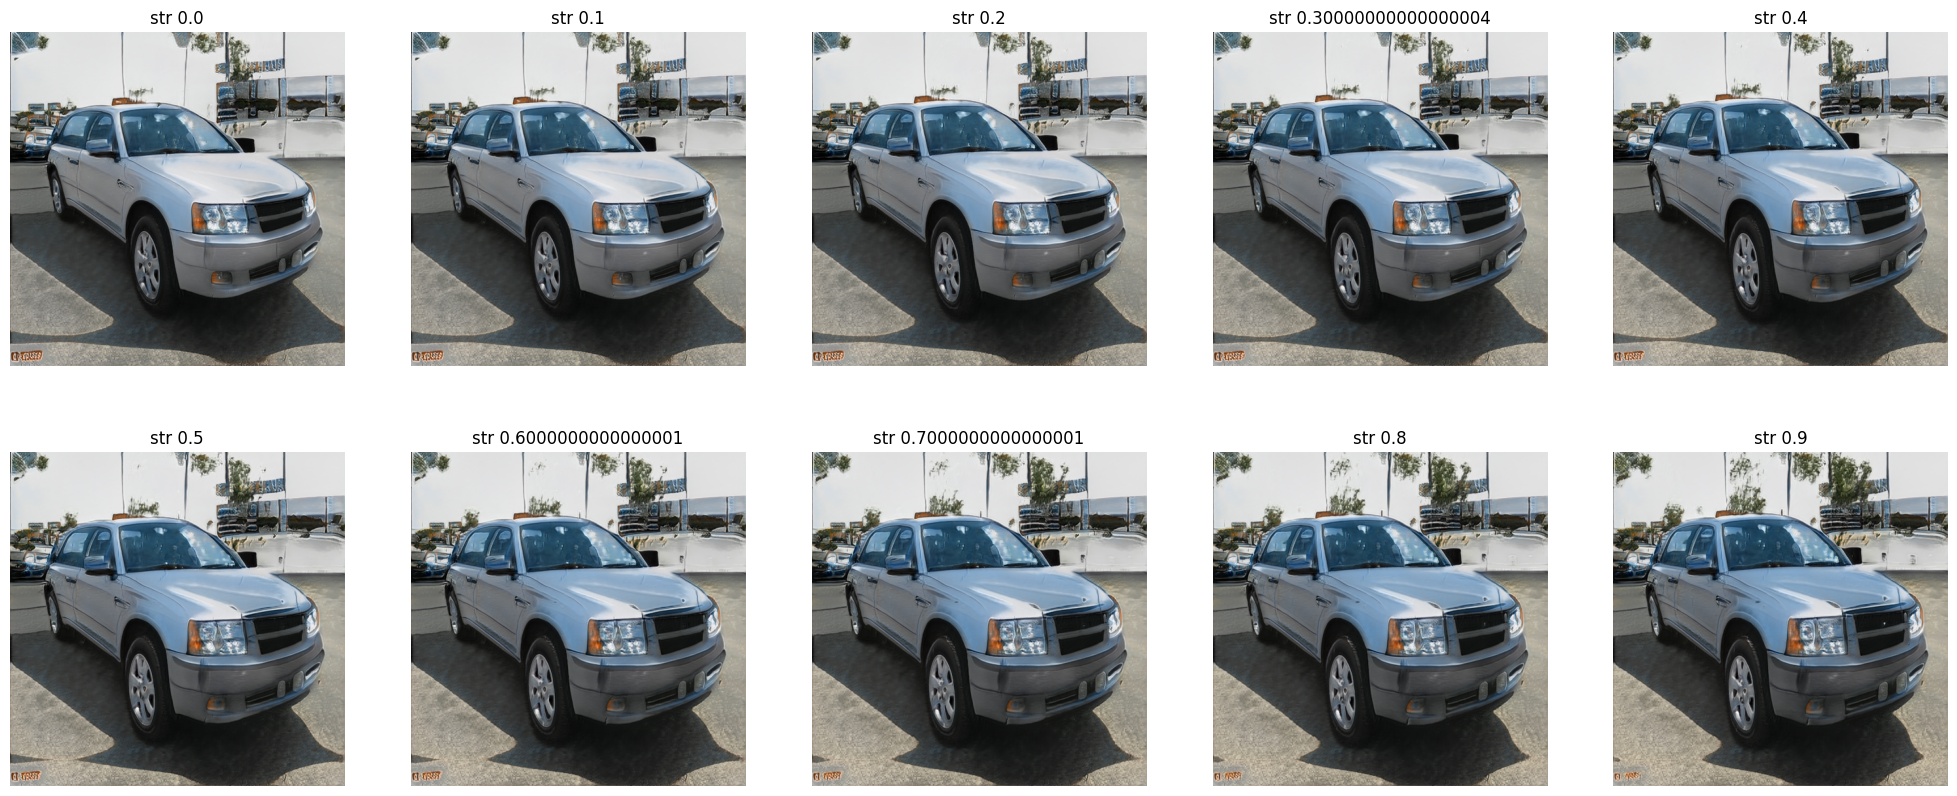

In [48]:
ORIGINAL_IMAGE_SEED = 1
DIRECTION_VECTOR = './cars/direction_vectors/vector_177.npy'

torch.manual_seed(ORIGINAL_IMAGE_SEED)
z = torch.randn(1, 512).to(device)
imgs = []

strs = np.arange(0, 1, 0.1)
for i in strs:
    imgs.append(generate_from_str(z,i,DIRECTION_VECTOR))

plot_images(imgs,strs)